In [1]:
from google.colab import files
import cv2
import os
import shutil
import matplotlib.pyplot as plt

import numpy as np
from numba import cuda
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1 # resuelve bug de versiones

# Kernel

In [2]:
@cuda.jit
def grayscale_kernel_2D(img_color, img_gray):
    """
    Kernel 2D que mapea las coordenadas (i, j) directamente usando
    índices de bloque y de hilo en las dimensiones X e Y.
    i = fila (altura), j = columna (ancho)
    """
    # Obtener las coordenadas 2D (i, j)
    # cuda.grid(2) devuelve (j, i) -> (column,row)
    j, i = cuda.grid(2)

    # Obtener las dimensiones de la imagen de salida (filas, columnas)
    rows, cols = img_gray.shape

    # Chequeo de límites
    # Asegurarse de que las coordenadas estén dentro de los límites de la imagen
    if i < rows and j < cols:
        # Acceder a los componentes de color de la imagen original
        R = img_color[i, j, 0]
        G = img_color[i, j, 1]
        B = img_color[i, j, 2]

        # Cálculo de la intensidad de gris
        # Se mantienen los coeficientes estándar
        gray_value = 0.2989 * R + 0.5870 * G + 0.1140 * B

        # Asignar el valor de gris al array de salida
        img_gray[i, j] = gray_value

# GPU Caller

In [7]:
def image_to_grayscale(img):

    # 'img' entra como uint8 (0-255)
    ROWS, COLUMNS, COLOR = img.shape

    # Transferir la imagen original a la GPU
    d_img_color = cuda.to_device(img)

    # Reservar memoria en GPU para la imagen de salida
    d_img_gray = cuda.device_array((ROWS, COLUMNS), dtype=np.float32)

    # Configuración del GRID
    threadsperblock = (16, 16)
    blockspergrid_x = (COLUMNS + threadsperblock[0] - 1) // threadsperblock[0]
    blockspergrid_y = (ROWS + threadsperblock[1] - 1) // threadsperblock[1]
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    print("blockspergrid: ",blockspergrid)

    # Lanzamiento
    grayscale_kernel_2D[blockspergrid, threadsperblock](d_img_color, d_img_gray)

    # Recuperar (copy_to_host ya sincroniza implícitamente)
    return d_img_gray.copy_to_host()

# Read Image

Saving pikachu.png to pikachu.png
Imagen cargada como NumPy array. Forma (H, W, C): 948x812x3


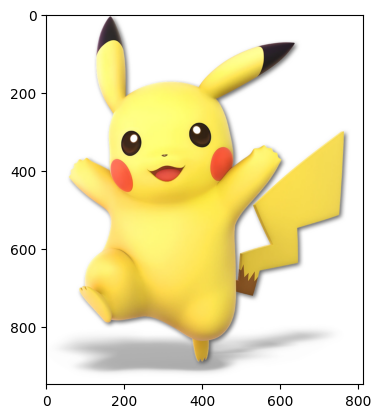

In [4]:
uploaded = files.upload()

img_color_name = list(uploaded.keys())[0]
img_color = cv2.imread(img_color_name)
img_color_cv_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
img_color_np = img_color_cv_rgb.astype(np.float32) / 255.0
H, W, C = img_color_np.shape
print(f"Imagen cargada como NumPy array. Forma (H, W, C): {H}x{W}x{C}")

plt.imshow(img_color_np)
plt.show()

# Logic

In [8]:
img_gray = image_to_grayscale(img_color_np)

blockspergrid:  (51, 60)


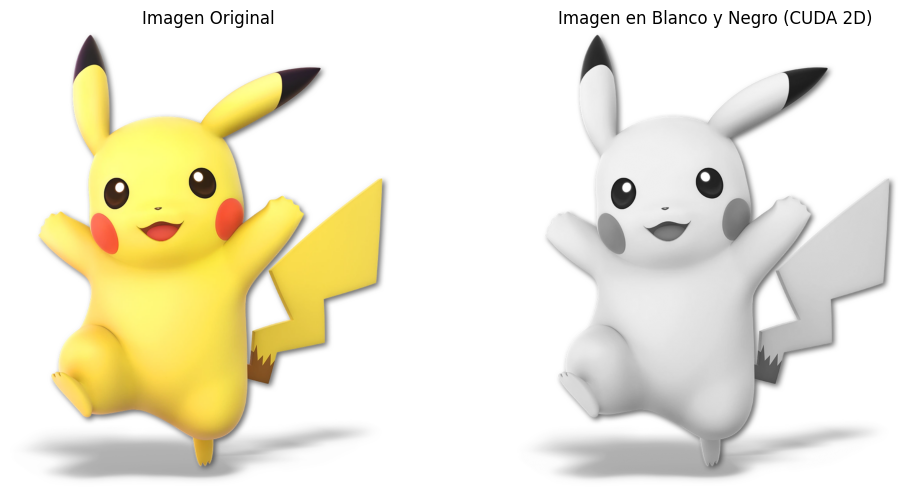

In [6]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
# img_np debe normalizarse si no está en el rango [0, 255]
plt.imshow(img_color_np / 255 if img_color_np.max() > 1 else img_color_np)
plt.title("Imagen Original")
plt.axis('off')

plt.subplot(1, 2, 2)
# El resultado es float32, usamos cmap='gray'
plt.imshow(img_gray, cmap='gray')
plt.title("Imagen en Blanco y Negro (CUDA 2D)")
plt.axis('off')

plt.show()